# Age, Gender & Expression Recognizer

## 1. Setup and Preparation

### 1.1 Import Libraries and Setting Up Device-agnostic code

In [1]:
import torch
import pandas as pd

from torch import nn
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

torch.__version__

'2.4.1+cu121'

In [2]:
# Setting device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1.2 Configuration

In [3]:
data_path = Path('/kaggle/input/')

AGE_FILE_PATH = data_path / 'facial-age'
EMOTION_FILE_PATH = data_path / 'facial-emotion-expressions'
GENDER_FILE_PATH = data_path / 'gender-recognizer'

In [4]:
AGE_FILE_PATH, EMOTION_FILE_PATH, GENDER_FILE_PATH

(PosixPath('/kaggle/input/facial-age'),
 PosixPath('/kaggle/input/facial-emotion-expressions'),
 PosixPath('/kaggle/input/gender-recognizer'))

### 1.3 Load Datasets

In [5]:
import os

def walk_throuhg_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [6]:
# walk_throuhg_dir(AGE_FILE_PATH)

In [7]:
# walk_throuhg_dir(EMOTION_FILE_PATH)

In [8]:
walk_throuhg_dir(GENDER_FILE_PATH)

There are 1 directories and 0 images in /kaggle/input/gender-recognizer
There are 2 directories and 0 images in /kaggle/input/gender-recognizer/dataset
There are 0 directories and 646 images in /kaggle/input/gender-recognizer/dataset/MEN
There are 1 directories and 646 images in /kaggle/input/gender-recognizer/dataset/WOMAN
There are 0 directories and 646 images in /kaggle/input/gender-recognizer/dataset/WOMAN/MEN


## Age Dataset Preprocessing

In [9]:
# List all file paths in the directory
paths = [path for path in AGE_FILE_PATH.rglob('*/*.png')]

# Create the DataFrame with relevant columns
age_df = pd.DataFrame({
    'file_path': paths,
    'file_name': [path.name for path in paths],  # Extract file name
    'label': [path.parts[-2] for path in paths]  # Extract folder name as label
})
age_df.head()

,file_path,file_name,label
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,057
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,057
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,057
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,057
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,057


In [10]:
age_df.shape

(19556, 3)

In [11]:
# Droping duplicated values
print(age_df.duplicated(['file_name', 'label']).sum())
age_df.drop_duplicates(['file_name', 'label'], inplace=True)

9778


In [12]:
age_df.shape

(9778, 3)

In [13]:
# Define bins and labels
age_bins = [0, 3, 12, 19, 28, 55, 70]
age_labels = ['Baby', 'Child', 'Teen', 'Young Adult', 'Adult', 'Elderly']

age_idx = {label:i for i, label in enumerate(age_labels)}
print(age_idx)

# Assign age categories based on bins
age_df['age_category'] = pd.cut(age_df['label'].astype(int), bins=age_bins, labels=age_labels, right=False)
age_df.head()

{'Baby': 0, 'Child': 1, 'Teen': 2, 'Young Adult': 3, 'Adult': 4, 'Elderly': 5}


,file_path,file_name,label,age_category
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,057,Elderly
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,057,Elderly
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,057,Elderly
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,057,Elderly
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,057,Elderly


In [14]:
age_df['label'].value_counts()

label
001    1112
002     475
003     284
026     279
004     260
       ... 
099       2
110       2
100       2
101       1
091       1
Name: count, Length: 99, dtype: int64

In [15]:
print(age_df.isnull().sum())
age_df.dropna(inplace=True)

file_path         0
file_name         0
label             0
age_category    794
dtype: int64


In [16]:
age_df['age_category'].value_counts()

age_category
Adult          2543
Baby           1587
Child          1562
Young Adult    1280
Elderly        1055
Teen            957
Name: count, dtype: int64

In [17]:
age_df.drop('label', axis=1, inplace=True)
print(age_df.shape)
age_df.head()

(8984, 3)


,file_path,file_name,age_category
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,Elderly
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,Elderly
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,Elderly
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,Elderly
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,Elderly


In [18]:
train_age_data, test_age_data = train_test_split(age_df, shuffle=True, test_size=0.1)
train_age_data, val_age_data = train_test_split(train_age_data, shuffle=True, test_size=0.2)
train_age_data.head()

,file_path,file_name,age_category
1503,/kaggle/input/facial-age/face_age/025/8352.png,8352.png,Young Adult
4901,/kaggle/input/facial-age/face_age/020/2819.png,2819.png,Young Adult
6923,/kaggle/input/facial-age/face_age/021/1593.png,1593.png,Young Adult
4999,/kaggle/input/facial-age/face_age/013/1362.png,1362.png,Teen
1613,/kaggle/input/facial-age/face_age/001/2169.png,2169.png,Baby


In [19]:
test_age_data.head()

,file_path,file_name,age_category
9352,/kaggle/input/facial-age/face_age/038/859.png,859.png,Adult
9343,/kaggle/input/facial-age/face_age/038/6896.png,6896.png,Adult
4777,/kaggle/input/facial-age/face_age/023/7096.png,7096.png,Young Adult
8893,/kaggle/input/facial-age/face_age/045/5347.png,5347.png,Adult
2208,/kaggle/input/facial-age/face_age/001/1030.png,1030.png,Baby


In [20]:
val_age_data.head()

,file_path,file_name,age_category
8234,/kaggle/input/facial-age/face_age/019/959.png,959.png,Young Adult
5615,/kaggle/input/facial-age/face_age/002/2533.png,2533.png,Baby
2151,/kaggle/input/facial-age/face_age/001/5883.png,5883.png,Baby
7948,/kaggle/input/facial-age/face_age/003/133.png,133.png,Child
2229,/kaggle/input/facial-age/face_age/001/3594.png,3594.png,Baby


In [21]:
train_age_data.shape, val_age_data.shape, test_age_data.shape

((6468, 3), (1617, 3), (899, 3))

### Data Transformation

In [22]:
# Define the transformation pipeline
train_transforms_trivial = transforms.Compose([
    transforms.Resize(size=(224, 224)),  # Resize to 224x224
    transforms.TrivialAugmentWide(num_magnitude_bins=31),  # Apply TrivialAugmentWide
    transforms.ToTensor()  # Convert to tensor
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),  # Resize to 224x224
    transforms.ToTensor()  # Convert to tensor
])

## Custom Dataset

In [23]:
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, file_paths, age_categories, age_idx, transform=None):
        """
        Args:
            file_paths (list): List of image file paths.
            age_categories (list): List of age categories corresponding to the images.
            age_idx (dict): Mapping of age categories to numerical indices.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.file_paths = list(file_paths)
        self.age_categories = list(age_categories)
        self.age_idx = age_idx
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Retrieve image path and age category
        img_path = self.file_paths[idx]
        age_category = self.age_categories[idx]

        # Map the age category to its corresponding index
        label_idx = self.age_idx[age_category]

        # Load the image
        img = Image.open(img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            img = self.transform(img)

        return img, label_idx

In [24]:
# Initialize the datasets
age_train_dataset = CustomDataset(
    file_paths=train_age_data['file_path'].tolist(),
    age_categories=train_age_data['age_category'].tolist(),
    age_idx=age_idx,
    transform=train_transforms_trivial
)

age_val_dataset = CustomDataset(
    file_paths=val_age_data['file_path'].tolist(),
    age_categories=val_age_data['age_category'].tolist(),
    age_idx=age_idx,
    transform=train_transforms_trivial
)

age_test_dataset = CustomDataset(
    file_paths=test_age_data['file_path'].tolist(),
    age_categories=test_age_data['age_category'].tolist(),
    age_idx=age_idx,
    transform=test_transforms
)

In [25]:
# Test the training dataset
img, label_idx = age_train_dataset[0]
print(f"Image size: {img.size()}, Label index: {label_idx}")

Image size: torch.Size([3, 224, 224]), Label index: 3


In [26]:
age_train_dataset[3]

(tensor([[[0.4863, 0.4824, 0.4784,  ..., 0.1020, 0.1059, 0.1059],
          [0.4902, 0.4863, 0.4824,  ..., 0.1059, 0.1059, 0.1059],
          [0.4902, 0.4863, 0.4824,  ..., 0.1020, 0.1020, 0.1098],
          ...,
          [0.0863, 0.0863, 0.0824,  ..., 0.0314, 0.0314, 0.0353],
          [0.0863, 0.0863, 0.0824,  ..., 0.0314, 0.0314, 0.0353],
          [0.0863, 0.0863, 0.0824,  ..., 0.0314, 0.0314, 0.0353]],
 
         [[0.2980, 0.2941, 0.2902,  ..., 0.0667, 0.0627, 0.0627],
          [0.3020, 0.2980, 0.2941,  ..., 0.0627, 0.0627, 0.0627],
          [0.3059, 0.3020, 0.2980,  ..., 0.0588, 0.0588, 0.0588],
          ...,
          [0.1020, 0.1020, 0.0980,  ..., 0.0314, 0.0314, 0.0353],
          [0.1020, 0.1020, 0.0980,  ..., 0.0314, 0.0314, 0.0353],
          [0.1020, 0.1020, 0.0980,  ..., 0.0314, 0.0314, 0.0353]],
 
         [[0.2431, 0.2392, 0.2353,  ..., 0.0471, 0.0471, 0.0471],
          [0.2471, 0.2431, 0.2392,  ..., 0.0471, 0.0471, 0.0471],
          [0.2510, 0.2471, 0.2431,  ...,

In [27]:
age_train_dataset.age_idx

{'Baby': 0, 'Child': 1, 'Teen': 2, 'Young Adult': 3, 'Adult': 4, 'Elderly': 5}

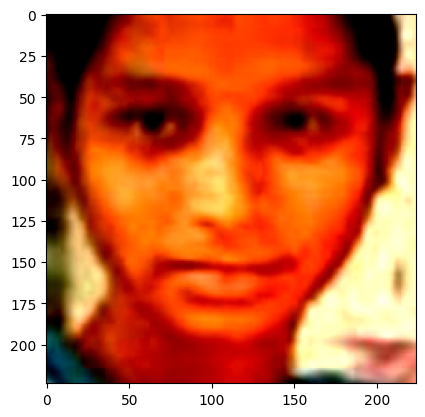

In [28]:
plt.imshow(age_train_dataset[0][0].permute(1, 2, 0))

In [29]:
import random
# Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset, 
                          classes:None, 
                          n: int = 10, 
                          display_shape: bool = True, 
                          seed: int = None):
    
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f'n should NOT be larger than 10')

    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Set plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor ddimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0)
    
        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        if classes:
            title = f'Class: {classes[targ_label]}'
            if display_shape:
                title = title + f'\nShape: {targ_image_adjust.shape}'
    
        plt.title(title)

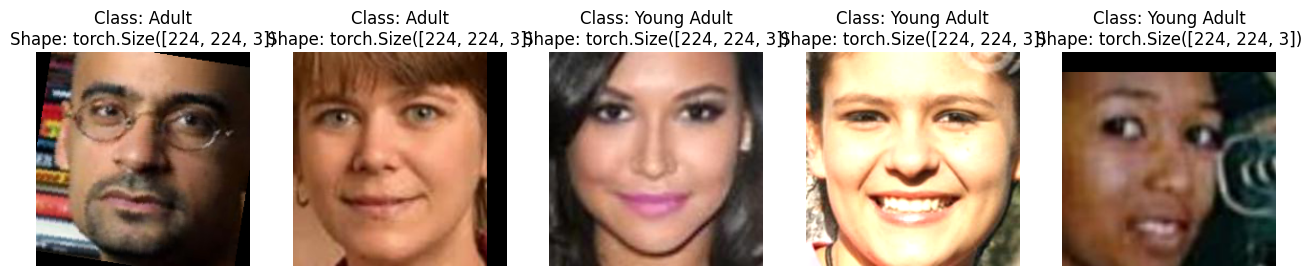

In [30]:
# Display random images from the the Custom Dataset
display_random_images(age_train_dataset, n=5,
                     classes=age_labels, seed=None)

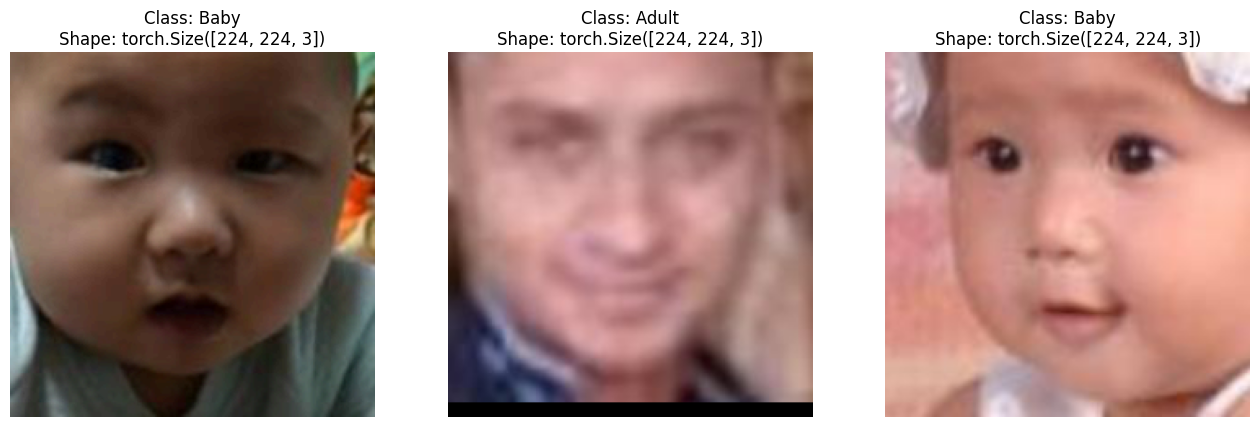

In [31]:
# Display random images from the the Custom Dataset
display_random_images(age_val_dataset, n=3,
                     classes=age_labels, seed=None)

## Create DataLoader

In [32]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
age_train_dataloader = DataLoader(dataset=age_train_dataset, 
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

age_val_dataloader = DataLoader(dataset=age_val_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                num_workers=NUM_WORKERS)

age_test_dataloader = DataLoader(dataset=age_test_dataset, 
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)